In [1]:
using CSV
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

LoadError: LoadError: ArgumentError: Package HypothesisTests not found in current path.
- Run `import Pkg; Pkg.add("HypothesisTests")` to install the HypothesisTests package.
in expression starting at /home/daniel/work/rfq-nn/stats.jl:2

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [5]:
first(x_raw_df, 5)

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,10.7561,51.3217,117.941,1.58493,1.80198,54.7152,46.9082,-73.5071,-40.3815
2,10.9999,59.0984,114.967,1.42384,1.632,94.2397,329.885,-69.9227,-61.021
3,10.5114,67.2372,102.822,1.56805,1.76104,232.236,482.175,-34.481,-31.0546
4,9.79078,132.062,157.89,1.06108,1.4818,91.7427,178.76,-35.0063,-28.2593
5,10.8851,33.3697,144.044,1.67219,1.83251,433.296,420.627,-32.8443,-26.0774


In [6]:
first(y_raw_df, 5)

,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5,OBJ6
,Float32,Float32,Float32,Float32,Float32,Float32
1,91.0,0.0624,99.34,0.07639,0.07035,0.05352
2,92.69,0.0579,110.26,0.07544,0.03639,0.05048
3,70.87,0.0649,80.55,0.07192,0.04194,0.02244
4,16.85,0.0756,183.99,0.01274,0.01483,0.01153
5,66.16,0.0674,56.7,0.06682,0.03004,0.04468


## EDA

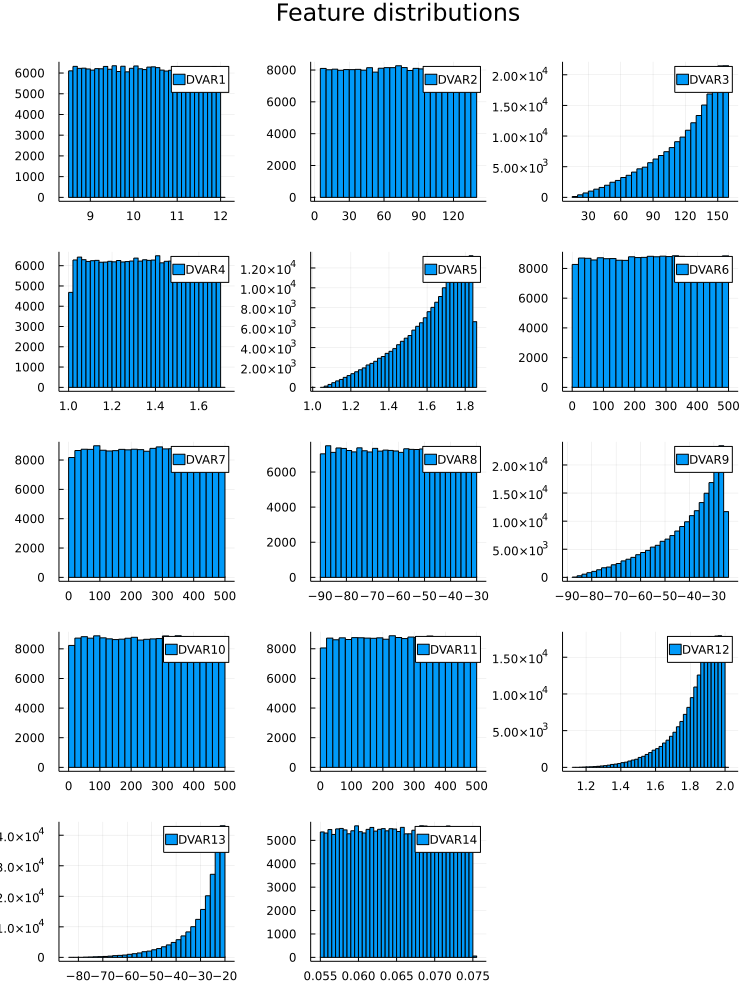

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_raw_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

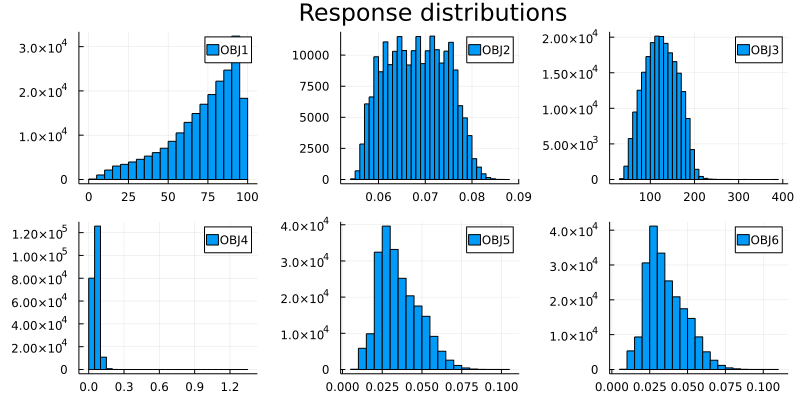

In [8]:
# plot responses
l = @layout [grid(2,3)]

subplots = []
for i in 1:6
    hist = histogram(y_raw_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout = l, size=(800, 400), plot_title="Response distributions")

In [9]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [10]:
# how many outliers are there?
sum((!).(non_outlier_conditional))

717

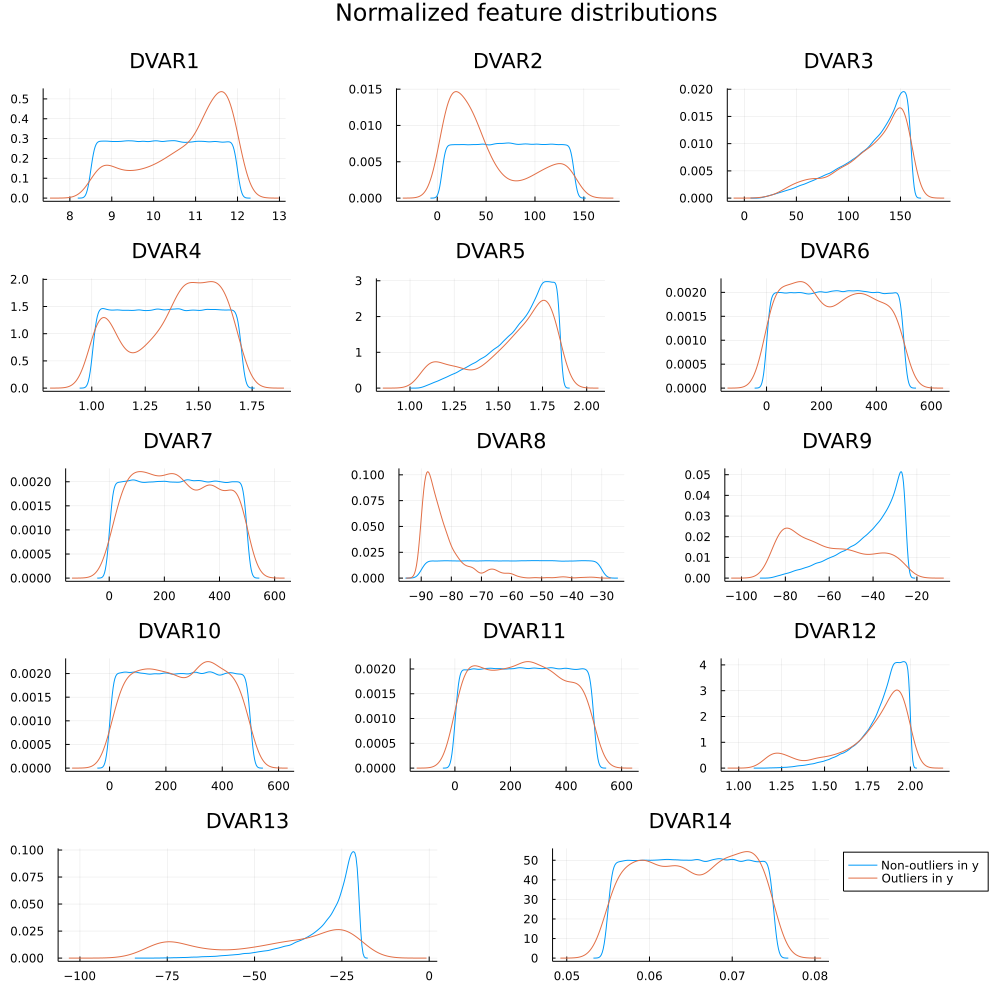

In [11]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [12]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [13]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [14]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [15]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [16]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [31]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [32]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [33]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=22.603148394209406
epoch 2, loss=19.86007071752611
epoch 3, loss=15.238589590100423
epoch 4, loss=13.17612444817091
epoch 5, loss=8.153163137555312
epoch 6, loss=7.699030586428163
epoch 7, loss=7.365436270447258
epoch 8, loss=5.966071950312782
epoch 9, loss=3.9097654446080283
epoch 10, loss=3.632330857404648
epoch 11, loss=3.4911938473822652
epoch 12, loss=3.3580364586160583
epoch 13, loss=3.2076143644071893
epoch 14, loss=3.0687838579888393
epoch 15, loss=2.9339216056851485
epoch 16, loss=2.8584441334010227
epoch 17, loss=2.802048832905248
epoch 18, loss=2.7629479516586937
epoch 19, loss=2.7365990493314816
epoch 20, loss=2.7041479506082546
epoch 21, loss=2.681414692059229
epoch 22, loss=2.6382086051635962
epoch 23, loss=2.623664912317818
epoch 24, loss=2.585265447886285
epoch 25, loss=2.5620646297321903
epoch 26, loss=2.599850014362863
epoch 27, loss=2.5331050126628667
epoch 28, loss=2.474240642571373
epoch 29, loss=2.440875201874318
epoch 30, loss=2.4279814783679448
epo

epoch 241, loss=1.6100632510989965
epoch 242, loss=1.638332707329823
epoch 243, loss=1.6309044983567196
epoch 244, loss=1.611666563814547
epoch 245, loss=1.6671822167080577
epoch 246, loss=1.6298279624558405
epoch 247, loss=1.6139286088223337
epoch 248, loss=1.624012710133071
epoch 249, loss=1.626582480817251
epoch 250, loss=1.6081639333756155
epoch 251, loss=1.6030522128756461
epoch 252, loss=1.6183671108406554
epoch 253, loss=1.6203586071013985
epoch 254, loss=1.6533511535534453
epoch 255, loss=1.6161894724520083
epoch 256, loss=1.6154710827389795
epoch 257, loss=1.596150154139048
epoch 258, loss=1.597073013959185
epoch 259, loss=1.5929275612147686
epoch 260, loss=1.618975194483592
epoch 261, loss=1.6083988987427695
epoch 262, loss=1.5985448898325292
epoch 263, loss=1.597853492583733
epoch 264, loss=1.5948365239309752
epoch 265, loss=1.6074107635056543
epoch 266, loss=1.651805352106773
epoch 267, loss=1.600000129202348
epoch 268, loss=1.5932309896297243
epoch 269, loss=1.594278115865

epoch 713, loss=1.4836889385373404
epoch 714, loss=1.4808988264285576
epoch 715, loss=1.478964365747951
epoch 716, loss=1.4780136322853328
epoch 717, loss=1.5024856422269932
epoch 718, loss=1.488498564936106
epoch 719, loss=1.4834099027301169
epoch 720, loss=1.475051191428211
epoch 721, loss=1.4848236131176777
epoch 722, loss=1.477406974909276
epoch 723, loss=1.4940319471543249
epoch 724, loss=1.4965475110913486
epoch 725, loss=1.4763795760340668
epoch 726, loss=1.4830870241082583
epoch 727, loss=1.4810764112950832
epoch 728, loss=1.4863478130720225
epoch 729, loss=1.488648518565059
epoch 730, loss=1.4950700297169375
epoch 731, loss=1.4841028672928658
epoch 732, loss=1.4820587837485264
epoch 733, loss=1.4819723760208026
epoch 734, loss=1.4694502683027915
epoch 735, loss=1.4781188994990917
epoch 736, loss=1.4799533703186525
epoch 737, loss=1.4808270388090687
epoch 738, loss=1.488643510863005
epoch 739, loss=1.4762177770710556
epoch 740, loss=1.470460655365566
epoch 741, loss=1.485561538

epoch 949, loss=1.4451792106373953
epoch 950, loss=1.468804062040676
epoch 951, loss=1.462394524899404
epoch 952, loss=1.4484679523665502
epoch 953, loss=1.4579759053706065
epoch 954, loss=1.4704050310794652
epoch 955, loss=1.4619435049862601
epoch 956, loss=1.4492929620358617
epoch 957, loss=1.4523194769922254
epoch 958, loss=1.4703546813373063
epoch 959, loss=1.4440192246677355
epoch 960, loss=1.446208324144863
epoch 961, loss=1.4528656123932433
epoch 962, loss=1.4516487183524327
epoch 963, loss=1.4441459390115485
epoch 964, loss=1.444287064998626
epoch 965, loss=1.4433310548189289
epoch 966, loss=1.4460303477932148
epoch 967, loss=1.4508971222781017
epoch 968, loss=1.4470852517531048
epoch 969, loss=1.4503574283440137
epoch 970, loss=1.4461197329767836
epoch 971, loss=1.4470813133624691
epoch 972, loss=1.4646209266799037
epoch 973, loss=1.4446123553230357
epoch 974, loss=1.445489337566816
epoch 975, loss=1.4396069943329945
epoch 976, loss=1.4408973425032727
epoch 977, loss=1.4446615

epoch 1408, loss=1.4167441844456392
epoch 1409, loss=1.4081000709792237
epoch 1410, loss=1.3965395821904316
epoch 1411, loss=1.4094416918370183
epoch 1412, loss=1.3996774710779258
epoch 1413, loss=1.4014593486516518
epoch 1414, loss=1.4117632255347863
epoch 1415, loss=1.406139113865247
epoch 1416, loss=1.4016438807354565
epoch 1417, loss=1.3982094066312996
epoch 1418, loss=1.3956652852996398
epoch 1419, loss=1.3952800191775192
epoch 1420, loss=1.3999216775362613
epoch 1421, loss=1.397933936496478
epoch 1422, loss=1.3955768645402247
epoch 1423, loss=1.3984853728614253
epoch 1424, loss=1.4020120735824846
epoch 1425, loss=1.4045547781068715
epoch 1426, loss=1.3929787449314137
epoch 1427, loss=1.3975631428905975
epoch 1428, loss=1.4018487142677005
epoch 1429, loss=1.3986320961908396
epoch 1430, loss=1.401887952671152
epoch 1431, loss=1.3947075301732446
epoch 1432, loss=1.4070899767554066
epoch 1433, loss=1.4034163428586084
epoch 1434, loss=1.3985586140373734
epoch 1435, loss=1.406285810945

epoch 1866, loss=1.3752948491267376
epoch 1867, loss=1.365116782526191
epoch 1868, loss=1.3630707414174463
epoch 1869, loss=1.3788519543828988
epoch 1870, loss=1.3640605203013263
epoch 1871, loss=1.3682916988356664
epoch 1872, loss=1.3634543770238647
epoch 1873, loss=1.366245954599912
epoch 1874, loss=1.3648312319700322
epoch 1875, loss=1.370213039784768
epoch 1876, loss=1.3718550835312884
epoch 1877, loss=1.3728475045658373
epoch 1878, loss=1.3762602794575514
epoch 1879, loss=1.3700612064796303
epoch 1880, loss=1.3636653470406694
epoch 1881, loss=1.3822731431934783
epoch 1882, loss=1.365929190452403
epoch 1883, loss=1.371049662469005
epoch 1884, loss=1.3673106940816744
epoch 1885, loss=1.3676079477744092
epoch 1886, loss=1.3726467438585652
epoch 1887, loss=1.3642016523715312
epoch 1888, loss=1.3613748551100744
epoch 1889, loss=1.3612311897627265
epoch 1890, loss=1.3826467764535506
epoch 1891, loss=1.368922446880217
epoch 1892, loss=1.369026778009013
epoch 1893, loss=1.3673660161950634

epoch 2324, loss=1.3518017950751828
epoch 2325, loss=1.3413566858309443
epoch 2326, loss=1.361691366520283
epoch 2327, loss=1.350464369459508
epoch 2328, loss=1.3429145771746707
epoch 2329, loss=1.3445982505437637
epoch 2330, loss=1.339980749890166
epoch 2331, loss=1.342151737481472
epoch 2332, loss=1.3461491845882878
epoch 2333, loss=1.3502452783733019
epoch 2334, loss=1.3417037278382458
epoch 2335, loss=1.34725347509499
epoch 2336, loss=1.350424108320672
epoch 2337, loss=1.3381301220818467
epoch 2338, loss=1.3431749106740525
epoch 2339, loss=1.3413019838703168
epoch 2340, loss=1.351120895403964
epoch 2341, loss=1.3398990444120924
epoch 2342, loss=1.346745110750419
epoch 2343, loss=1.3562042278529058
epoch 2344, loss=1.3432001907005753
epoch 2345, loss=1.338031760654448
epoch 2346, loss=1.3409144199687637
epoch 2347, loss=1.3468452636459332
epoch 2348, loss=1.3521793969988158
epoch 2349, loss=1.353530058231368
epoch 2350, loss=1.3560939328354937
epoch 2351, loss=1.3424647036380486
epo

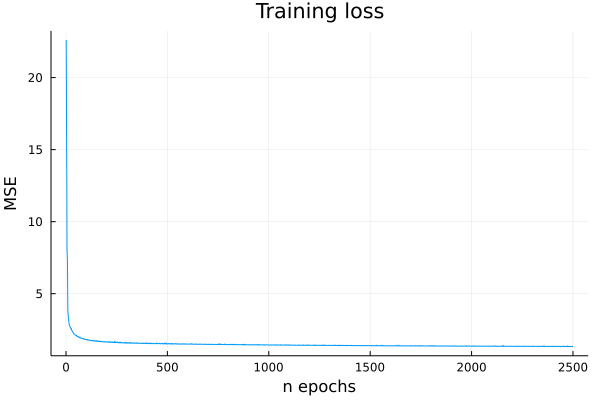

In [44]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [45]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [46]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9341134859630659
r2 on test set: 0.9329632530959553


In [47]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [48]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9341081616466558
adjustedr2 on test set: 0.9329415788977462


In [49]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.05963266058046361
mae on test set: 0.060115117354886276


In [50]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.018896501407778262
mae on test set for OBJ1: 0.019200189109563743
mae on training set for OBJ2: 0.0746173301406421
mae on test set for OBJ2: 0.07550523157522057
mae on training set for OBJ3: 0.015313161866272327
mae on test set for OBJ3: 0.01545933114064084
mae on training set for OBJ4: 0.031256019428403135
mae on test set for OBJ4: 0.03146338935996935
mae on training set for OBJ5: 0.10922624965452503
mae on test set for OBJ5: 0.11009038908110452
mae on training set for OBJ6: 0.10848670098516083
mae on test set for OBJ6: 0.10897217386281863


In [51]:
#=== redefine minmaxscaler for now ===#
function minmax_fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function minmax_transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function minmax_inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function minmax_fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    minmax_fit!(scaler, data)
    minmax_transform(scaler, data)
end

minmax_fit_transform (generic function with 1 method)

In [52]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [53]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    minmax_fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_preds_original = minmax_inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = minmax_inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = minmax_inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = minmax_inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.017222164541970397
MAPE on test set for OBJ2: 0.01812846207257422
MAPE on test set for OBJ3: 0.012291452065235235
MAPE on test set for OBJ4: 0.05596645014793377
MAPE on test set for OBJ5: 0.11576167693451303
MAPE on test set for OBJ6: 0.11392119681222171


**Summary**

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

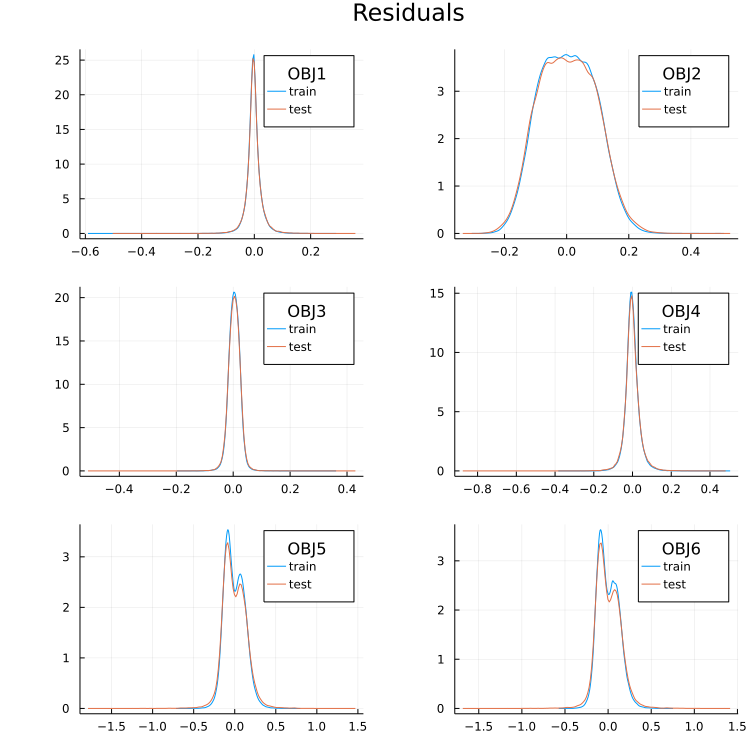

In [59]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

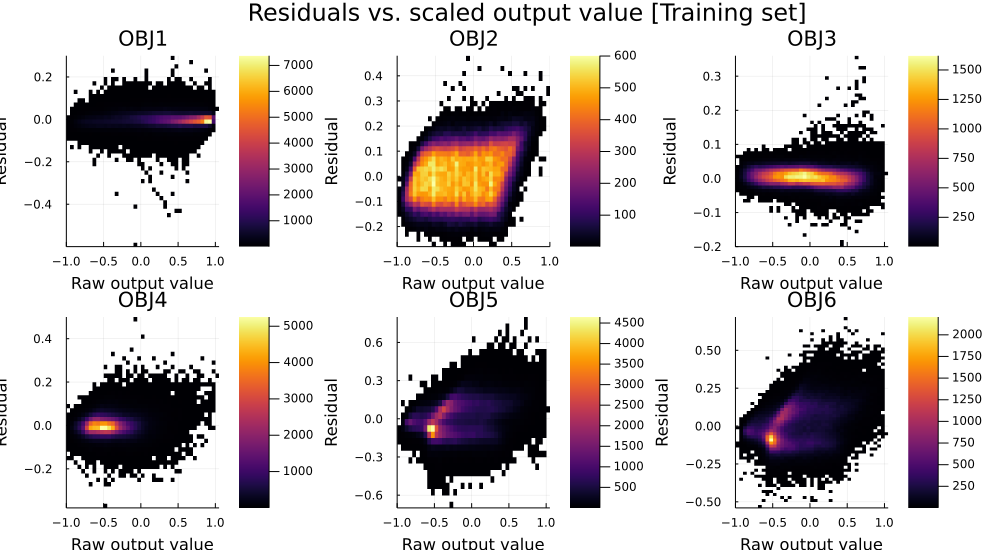

In [60]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

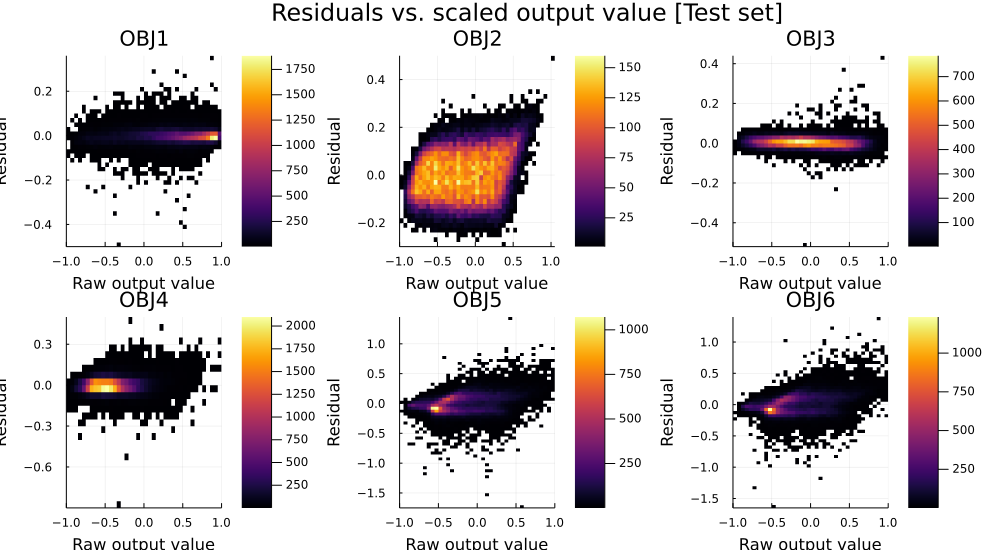

In [61]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")